### step5 Function

In [3]:
import numpy as np

class Variable:
  def __init__(self, data):
    self.data = data

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    self.input = input
    self.output = output
    return output

  def backward(self, x):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    return x ** 2

class Exp(Function):
  def forward(self, x):
    return np.exp(x)

# 微分法求导
def numerical_diff(f: Function, x: Variable, eps=1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

In [4]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
dy

4.000000000004

In [5]:
def f(x):
  A = Square()
  B = Exp()
  C = Square()
  return C(B(A(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x)
dy

3.2974426293330694

### step6 backward

In [13]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    
class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

In [14]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
y.data

1.648721270700128

In [12]:
import math as math
(math.exp(0.5 ** 2) ** 2)

1.648721270700128

In [15]:
y.grad = np.array(1.0)
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
x.grad

3.297442541400256

### step7 creator

In [24]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    f = self.creator
    if f is not None:
      x = f.input
      x.grad = f.backward(self.grad)
      x.backward()

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()
  
class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

In [25]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()

print(x.grad)

3.297442541400256


### step8 

In [26]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)
    
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()

print(x.grad)

3.297442541400256


### step9

In [27]:
def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


In [29]:
def as_array(x):
  if np.isscalar(x):
    return np.array(x)
  return x

class Variable:
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError(f'{type(data)} is not supported')
      
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func: Function):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

class Function:
  def __call__(self, input: Variable) -> Variable:
    x = input.data
    y = self.forward(x)
    output = Variable(as_array(y))
    output.set_creator(self)
    self.input = input
    self.output = output
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()
  
class Square(Function):
  def forward(self, x):
    return x ** 2

  def backward(self, gy):
    x = self.input.data
    gx = 2 * x * gy
    return gx
  
class Exp(Function):
  def forward(self, x):
    return np.exp(x)
  
  def backward(self, gy):
    x = self.input.data
    gx = np.exp(x) * gy
    return gx

def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

x = Variable(np.array(0.5))
y = square(exp(square(x)))
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


### step27 my_sin

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

In [4]:
import numpy as np
import math
from grad import Variable, Function
from grad.utils import plot_dot_graph

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx
  
def sin(x):
  return Sin()(x)

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


In [5]:
def my_sin(x, threshold=0.0001):
  y = 0
  for i in range(100000):
    c = (-1) ** i / math.factorial(2 * i + 1)
    t = c * x ** (2 * i + 1)
    y = y + t
    if abs(t.data) < threshold:
      break
  return y

x = Variable(np.array(np.pi/4))
y = my_sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


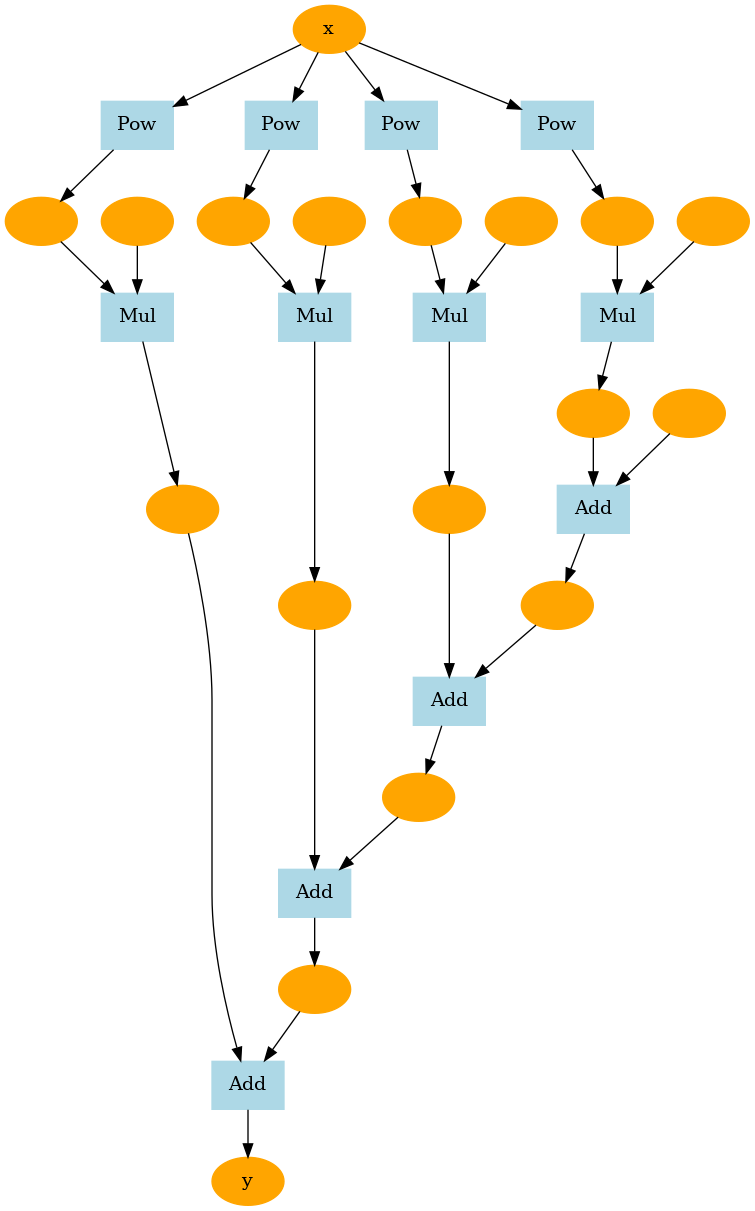

In [6]:
x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')

### step33 

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable, Function

def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward(create_graph=True)
  # 一阶导数 梯度
  gx = x.grad
  x.cleargrad()
  gx.backward()
  # 二阶导数 梯度
  gx2 = x.grad
  # 牛顿法
  x.data -= gx.data / gx2.data
    

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


### step35

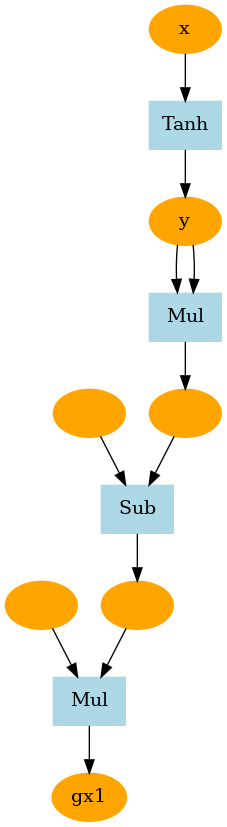

In [5]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable, Function
from grad.utils import plot_dot_graph
import grad.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 0

for i in range(iters):
  gx = x.grad
  x.cleargrad()
  gx.backward(create_graph=True)

gx2 = x.grad
gx2.name = 'gx' + str(iters + 1)
plot_dot_graph(gx2, verbose=False, to_file='tanh.png')


### step42

In [1]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable
import grad.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
  y = F.matmul(x, W) + b
  return y

def mean_squared_error(x0, x1):
  diff = x0 - x1
  return F.sum(diff ** 2) / len(diff)

lr = 0.1
iters = 100

for i in range(iters):
  y_pred = predict(x)
  loss = mean_squared_error(y, y_pred)

  W.cleargrad()
  b.cleargrad()
  loss.backward()

  W.data -= lr * W.grad.data
  b.data -= lr * b.grad.data
  print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.554280381353593)
variable([[2.21482401]]) variable([4.52705574]) variable(1.492599869047195)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756939)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227455)
variable([[2.39573972]]) variable([4.9467725]) variable(0.3585915308319281)
variable([[2.425382]]) variable([5.02561369]) variable(0.24915731977561134)
variable([[2.44575118]]) variable([5.08588371]) variable(0.1869065876539789)
variable([[2.45917205]]) variable([5.13217364]) variable(0.1513533629631488)
variable(

### step43

In [1]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable
import grad.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.randn(H, O))
b2 = Variable(np.zeros(O))

def predict(x):
  y = F.linear(x, W1, b1)
  y = F.sigmoid(y)
  y = F.linear(y, W2, b2)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y, y_pred)

  W1.cleargrad()
  b1.cleargrad()
  W2.cleargrad()
  b2.cleargrad()
  loss.backward()

  W1.data -= lr * W1.grad.data
  b1.data -= lr * b1.grad.data
  W2.data -= lr * W2.grad.data
  b2.data -= lr * b2.grad.data
  if i % 1000 == 0:
    print(loss)

variable(0.8473695850105871)
variable(0.2514286285183606)
variable(0.24759485466749873)
variable(0.23786120447054826)
variable(0.2122223133310296)
variable(0.16742181117834185)
variable(0.09681932619992661)
variable(0.07849528290602331)
variable(0.0774972955299115)
variable(0.07722132399559314)


### step44

In [1]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

import numpy as np
from grad import Variable
import grad.functions as F
import grad.layers as L

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

def predict(x):
  y = l1(x)
  y = F.sigmoid(y)
  y = l2(y)
  return y

lr = 0.2
iters = 10000

for i in range(iters):
  y_pred = predict(x)
  loss = F.mean_squared_error(y, y_pred)

  l1.cleargrads()
  l2.cleargrads()
  loss.backward()

  for l in [l1, l2]:
    for p in l.params():
      p.data -= lr * p.grad.data
  if i % 1000 == 0:
    print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


### step45

In [2]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

from grad import Variable, Model
import grad.functions as F
import grad.layers as L
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

l1 = L.Linear(10)
l2 = L.Linear(1)

lr = 0.2
iters = 10000
hidden_size = 10

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
    
    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y
    
model = TwoLayerNet(hidden_size, 1)

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.2372159081431807)
variable(0.20793216413350177)
variable(0.12311905720649349)
variable(0.07888166506355149)
variable(0.07655073683421633)
variable(0.07637803086238223)
variable(0.07618764131185574)


### step51

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '../src'))

from grad import Variable, Model
import grad.functions as F
import grad.layers as L
import numpy as np
import grad

np.random.seed(0)

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = grad.datasets.MNIST(train=True)
test_set = grad.datasets.MNIST(train=False) 